![UiO Logo](https://www.uio.no/om/designmanual/images/1-2-3-logo-universitetet-i-oslo.jpg "UiO Logo")

# The N-Queens Puzzle
by Marius Aasan (mariuaas$(\alpha)$math$\cdot$uio$\cdot$no) - IN3050/4050 Group 3 - 08.02.2021 1015-1200

The [8-queens puzzle](https://en.wikipedia.org/wiki/Eight_queens_puzzle) is a combinatorial optimization problem where one tries to place 8 queens on a chessboard without any of the queens being in a position to capture one another. In principle, a candidate solution can be obtained by placing the queens randomly over the board. However, this would create a very large solution space. Instead, we represent the genotypes as permutations, such that each queen can occupy a single rank and file. This leaves only the diagonals to be checked. Let us solve this problem with a genetic algorithm and generalize to an $N \times N$ grid.

#### Note:
Some of the code in this notebook as to not crash with the mandatory assignment, but can be filled out as an exercise.

Firstly we define the 'magic' function to plot directly in the Notebook.

In [1]:
%matplotlib inline

Now we import our libraries. We use our the workhorses [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/).

In [2]:
import numpy as np
import matplotlib.pyplot as plt

First, let's define a function to generate random permutations. We specify the `length=8` so we can later generalize the problem to higher dimensionality.

In [3]:
def random_genotype(length=8):
    return np.random.choice(np.arange(length), size=length, replace=False)

Using this function, we can define a function to generate a full population of size $n$.

In [4]:
def generate_population(n, length=8):
    population = np.zeros((n, length), dtype=int)
    for i in range(n):
        population[i] = random_genotype(length=length)
    return population

### Drawing a board

Now let us define a function to draw a board. We use a small trick with `np.indices` with the modulo operator to generate the board. We then select some appropriate [color map](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) to draw the generated matrix as a checkerboard, and draw pieces with the `plt.text` function on our board. The unicode string for a queen piece is `u"\u265B"`.

In [5]:
def draw_board(board, length=8, fontsize=42):
    # Create board matrix of 0s and 1s
    board_img = np.indices((length,length)).sum(axis=0) % 2

    # Create a figure and draw our matrix
    fig, ax = plt.subplots(figsize=(7,7))
    ax.matshow(board_img, cmap="tab20c")
    
    # Draw the pieces
    for i in range(length):
        ax.text(i, board[i], u"\u265B", fontsize=fontsize, ha="center", va="center")
    
    # Turn off axes and ticks
    plt.axis("off")
    
    # Return ax to possibly draw additional lines or points on our figure
    return ax

Okay, so now let's test our visualization on a random genotype.

[6 3 2 5 1 4 0 7]


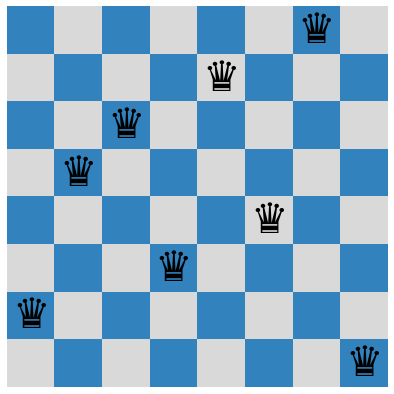

In [6]:
board = random_genotype()
print(board)
draw_board(board);

Notice that the genotype encodes the file of a queen on a particular rank (column).

### Defining Fitness

The fitness of the board should represent how good a particular solution really is to being optimal, i.e. having zero capture possibilities along the diagonals. Thus, we want to find a good way to check the diagonals to score our solutions with a fitness function. Notice that each diagonal can be encoded by a increasing sequence of integers for the negative diagonals, and an increasing sequence for the positive diagonals.

In [7]:
length = 8
diag = np.arange(0, 2*length)
diag[length:] = -1
print("Board:    ", board)
print("Diagonal: ", diag[:8])
print("Matches:  ", (board == diag[:8]).astype(int))

Board:     [6 3 2 5 1 4 0 7]
Diagonal:  [0 1 2 3 4 5 6 7]
Matches:   [0 0 1 0 0 0 0 1]


We will leverage this and generate a matrix of diagonals we can use to compare with a genotype to check if any diagonals have two or more pieces on it.

In [8]:
def make_diags(length=8):
    # Make the main diagonal
    diag = np.arange(0, 2*length)
    diag[length:] = -1

    # Create matrix of diagonals
    diags = np.zeros((4*length, length))
    for i in range(2*length):
        # Roll over elements in diag to generate each diagonal
        diags[i] = np.roll(diag, i)[:length]          # Negative
        diags[-i-1] = np.roll(diag[::-1], i)[:length] # Positive
    return diags
        
diags = make_diags()
diags

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
       [-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.],
       [-1., -1.,  0.,  1.,  2.,  3.,  4.,  5.],
       [-1., -1., -1.,  0.,  1.,  2.,  3.,  4.],
       [-1., -1., -1., -1.,  0.,  1.,  2.,  3.],
       [-1., -1., -1., -1., -1.,  0.,  1.,  2.],
       [-1., -1., -1., -1., -1., -1.,  0.,  1.],
       [-1., -1., -1., -1., -1., -1., -1.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1.],
       [ 7., -1., -1., -1., -1., -1., -1., -1.],
       [ 6.,  7., -1., -1., -1., -1., -1., -1.],
       [ 5.,  6.,  7., -1., -1., -1., -1., -1.],
       [ 4.,  5.,  6.,  7., -1., -1., -1., -1.],
       [ 3.,  4.,  5.,  6.,  7., -1., -1., -1.],
       [ 2.,  3.,  4.,  5.,  6.,  7., -1., -1.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7., -1.],
       [-1., -1., -1., -1., -1., -1., -1.,  7.],
       [-1., -1., -1., -1., -1., -1.,  7.,  6.],
       [-1., -1., -1., -1., -1.,  7.,  6.,  5.],
       [-1., -1., -1., -1.,  7.,  6.,  5.,  4.],
       [-1., -1., -1

Now we have a 2D array of diagonals which we can loop over to check each diagonal. Note however that this is not optimal. We have certain diagonals which are filled with only negative values, acting as placeholders. These will never match with any values. Additionally we have 4 diagonals with only a single non-negative value. These represent the corners of the board, and 4 of these are superflous.

However, this performance hit is minor, so we will ignore this for the purposes of this example. Feel free to correct this if you want! :)

We move on to explicitly define our fitness function. Additionally we would like to visualize how good a solution is, by drawing lines through the pieces that are in a capturable state. We do this by adding a `debug` flag to our fitness function, which we use to print out the capturable diagonals and adding lines to a visualized board.

In [9]:
def fitness(board, length=8, fontsize=40, debug=False):
    # Create a counter of captures and list of capture locations
    captures = 0
    locs = []

    # Loop through diagonals
    for i in range(2*length):
        # Define boolean array of negative and positive diagonals
        nd = board == diags[i]
        pd = board == diags[-i-1]
        
        # Count the number of pieces on a diagonal
        sum_nd, sum_pd = sum(nd), sum(pd)
        
        # Check if negative diagonal has more than two queens
        if sum_nd > 1:
            captures += sum_nd
            if debug:
                # Find squares, add min and max square along diagonal and print
                squares = np.where(nd)[0]
                locs += [(min(squares), max(squares))]
                print("neg: ", squares)
        
        # Check if positive diagonal has more than two queens
        if sum_pd > 1:
            captures += sum_pd
            if debug:
                # Find squares, add min and max square along diagonal and print
                squares = np.where(pd)[0]
                locs += [(min(squares), max(squares))]
                print("pos: ", squares)
    
    # If debug flag, we want to visualize the board
    if debug:
        
        # Get visualization
        ax = draw_board(board, length=length, fontsize=fontsize)

        # For each diagonal draw a line between the pieces
        for a,b in locs:
            x1, y1 = a, board[a]
            x2, y2 = b, board[b]
            ax.plot((x1,x2),(y1,y2), color="red")
    
    return captures  


Let us test our function to see if it works as intended.

neg:  [2 7]
pos:  [1 2]
pos:  [0 6]
neg:  [1 3]


8

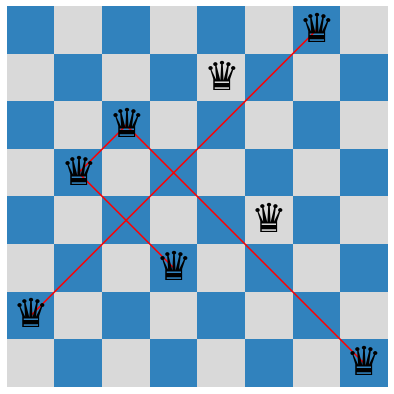

In [10]:
fitness(board, debug=True)

Very nice. We now have a way of visualizing our solution. Lastly, we want to time our fitness function without the debug flag.

In [11]:
%%timeit
fitness(board)

1000 loops, best of 5: 547 µs per loop


### Defining GA Operators

Next, we need to define our GA operators. For the purposes of this example, we will omit the code as it is important that you do this yourself for the mandatory assignment.

In [12]:
def PMX(parent1, parent2, length=8):
    # Partially mapped crossover. Insert your own code here.
    # ...
    return child

def SWM(child, p=0.5):
    # Swap mutation. Insert your own code here.
    # NOTE: This is an inplace operation which modifies the input directly.
    # ...


Once these are defined, we want to check that they work correctly.

In [14]:
parent1 = random_genotype()
parent2 = random_genotype()
print(parent1)
print(parent2)
child = PMX(parent1, parent2)
print(child)

[0 3 5 4 6 2 7 1]
[6 7 4 1 3 0 5 2]
[6 7 4 1 3 2 0 5]


The PMX operator seems to work as expected. Let's check the mutation operator.

In [15]:
print(child)
SWM(child, p=1)
print(child)

[6 7 4 1 3 2 0 5]
[6 7 4 1 3 0 2 5]


Nice! This seems to work as intended.

### Utility Functions

Next, we want to add some functions to score our population and retrieve a list of indices sorted by score. 

In [16]:
def score_population(population, length=8):
    # Score population
    scores = np.array(list(map(lambda x: fitness(x, length=length), population)))
    
    # Create sorted indices
    indices = np.argsort(scores)
    
    return scores, indices 
    

Now we create a function to create a new generation. This means implementing the selection process.

For our purposes, we make a simple selection process:
* We set a ratio (`top_ratio`) of the highest fitness individuals, and select a subset of these for procreation (`fertility_rate`).
* This selects a number of high fitness candidates which are selected for procreation. We select an additional group at random from the rest of the population as additional parents.
* All the subsequent offspring are then added to a list, called `children`.
* We set a mutation chance (`mutation_chance`) and apply a swap mutation to all the generated offspring with a set probability.
* We then replace a set of the less fit population with the newly formed offspring.

The code is omitted for the same reasons mentioned above, but feel free to implement this as an exercise! This is useful for the mandatory assignment.

In [20]:
def new_generation(population, top_ratio=0.15, fertility_rate=0.8, length=8, mutation_chance=0.5):
    # Perform parent selection, apply PMX and SWM to produce offspring, and apply survival selection.
    # ...
    scores, indices = score_population(population, length=length)
    return np.mean(scores), np.std(scores), np.min(scores), np.max(scores)

### Plotting the Process

To check if the 'training' process is proceeding as intended, we want to plot some key statistics from our population. The `new_generation` function returns the mean, standard deviation, as well as the minimum and maximum scores. We define a function that can take a list of these and plot the results.

In [21]:
def plot_results(trace):
    
    # Create the plots
    plt.plot(trace[:,0], label="$\mu$")
    plt.plot(trace[:,1], label="$\sigma$")
    plt.plot(trace[:,2], label="$min$")
    plt.plot(trace[:,3], label="$max$")
    
    # Set a log-scale to the y-axis
    plt.yscale("symlog")
    
    # Remember to label the axes!
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    
    # Set a maximum and minimum for the y values in the plot
    plt.ylim(0,np.max(trace) + 5)
    
    # Add a legend
    plt.legend()

### Running our Algorithm

We now have all the components necessary to run our algorithm. 

In [22]:
# Set number of generations
generations = 100

# Set the board size
length = 8

# Define the diagonals
diags = make_diags(length=length)

# Initialize the population
population = generate_population(25, length=length)

# Create a trace of all relevant population statistics
trace = []

# Run the algorithm
for gen in range(generations):

    # Create generations
    mean, std, mins, maxs = new_generation(population, length=length)
    trace.append([mean, std, mins, maxs])
    
    # Create a string containing useful statistics
    result = f"gen: {gen} - mean: {mean:5.2f} - std: {std:5.2f} - min: {mins}, max: {maxs}"

    # Print stats for every 5th iteration
    if gen % 5 == 0:
        print(result)

    # If the minimum solution is zero, print and stop.
    if mins == 0:
        print(result)
        break

# Convert list to array
trace = np.array(trace)

gen: 0 - mean:  7.60 - std:  2.15 - min: 2, max: 12
gen: 5 - mean:  7.44 - std:  2.14 - min: 2, max: 11
gen: 10 - mean:  6.88 - std:  2.18 - min: 2, max: 11
gen: 15 - mean:  6.56 - std:  2.08 - min: 2, max: 11
gen: 20 - mean:  6.64 - std:  2.38 - min: 2, max: 11
gen: 25 - mean:  6.44 - std:  2.47 - min: 2, max: 11
gen: 30 - mean:  5.96 - std:  2.47 - min: 2, max: 11
gen: 35 - mean:  5.20 - std:  2.24 - min: 2, max: 9
gen: 37 - mean:  4.96 - std:  2.54 - min: 0, max: 9


### Results

We seem to have found a solution! We plot the statistics and visualize the board.

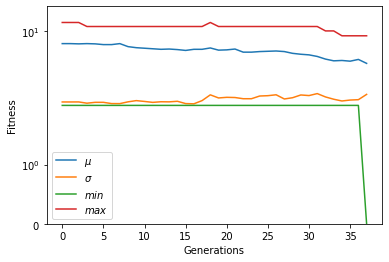

In [23]:
plot_results(trace)

0

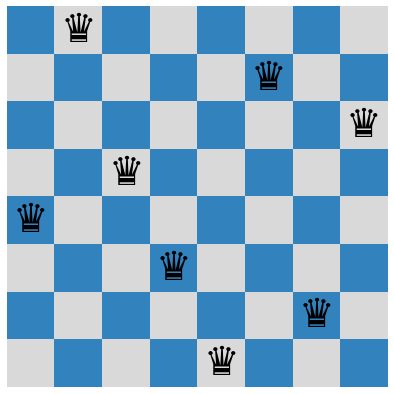

In [24]:
scores, indices = score_population(population)
fitness(population[indices[0]], length=8, debug=True)

This looks pretty good! However, this problem seems rather simple. If we initialize with a high enough population, the problem can be solved almost straight away, sometimes with 0 generations. If we however increase our dimensionality, the problem gets more difficult.

In [31]:
# Set the generations, board size, diagonals, initilaize pop, and trace
generations = 200
length = 12
diags = make_diags(length=length)
population = generate_population(200, length=length)
trace = []

# Run the algorithm
for gen in range(generations):

    mean, std, mins, maxs = new_generation(population, length=length)
    trace.append([mean, std, mins, maxs])
    result = f"gen: {gen} - mean: {mean:5.2f} - std: {std:5.2f} - min: {mins}, max: {maxs}"

    # Print stats for every 10th iteration this time
    if gen % 10 == 0:
        print(result)
    
    if mins == 0:
        print(result)
        break

# Convert list to array
trace = np.array(trace)

gen: 0 - mean: 10.80 - std:  2.51 - min: 3, max: 18
gen: 10 - mean:  9.91 - std:  2.57 - min: 3, max: 16
gen: 20 - mean:  9.66 - std:  3.07 - min: 3, max: 18
gen: 30 - mean:  9.50 - std:  3.21 - min: 3, max: 17
gen: 40 - mean:  9.20 - std:  3.31 - min: 3, max: 17
gen: 50 - mean:  8.89 - std:  3.23 - min: 3, max: 17
gen: 60 - mean:  8.61 - std:  3.34 - min: 2, max: 18
gen: 70 - mean:  8.84 - std:  3.67 - min: 2, max: 20
gen: 80 - mean:  8.59 - std:  3.45 - min: 2, max: 16
gen: 90 - mean:  8.80 - std:  3.40 - min: 2, max: 18
gen: 100 - mean:  8.89 - std:  3.50 - min: 2, max: 18
gen: 110 - mean:  8.89 - std:  3.59 - min: 2, max: 16
gen: 120 - mean:  8.48 - std:  3.66 - min: 2, max: 18
gen: 130 - mean:  8.30 - std:  3.63 - min: 2, max: 16
gen: 140 - mean:  8.33 - std:  3.85 - min: 2, max: 16
gen: 150 - mean:  8.38 - std:  3.84 - min: 2, max: 18
gen: 160 - mean:  8.59 - std:  4.09 - min: 2, max: 18
gen: 170 - mean:  8.66 - std:  4.16 - min: 2, max: 19
gen: 172 - mean:  8.40 - std:  4.01 - m

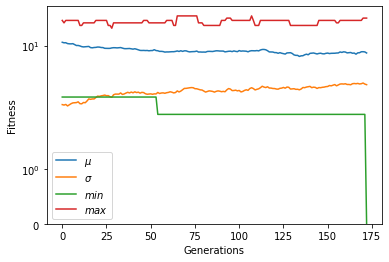

In [32]:
plot_results(trace)

0

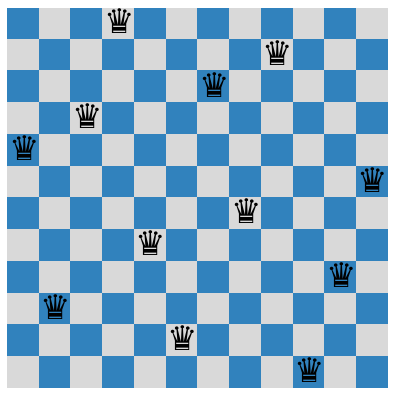

In [34]:
scores, indices = score_population(population, length=length)
fitness(population[indices[0]], length=length, fontsize=34, debug=True)

### Conclusion

It seems like our simple example works rather well. Hopefully you found this example useful. Many of the ideas here can be applied to the mandatory assignment so this is a good exercise with a smaller scale problem.